# Run these cells to get the accuracy for part d using the saved model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os

In [2]:
# Need to load the MNist data to work with
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)
# one hot true gives the y labels as vectors with 1's which correspond to the number it is

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
im_size = 28
im_flat = im_size**2

# Also have a dimsension of 10 for the one hot vectors.
num_digits = 10
units = 256

In [4]:
# Need to define Variables that will be optimized

# The Dimensionality of the weight vector to be able to multiply with 
# x and won't havr
def W(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    #return tf.Variable(tf.zeros(shape))
    
    
def b(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
    #return tf.Variable(tf.zeros(length))

In [5]:
# Need to define the filter size and the number of filters
# want (3,3,16): 16 3x3 filters
filter_size1 = 3
num_filters1 = 16

#second convoultional layer
filter_size2 = 3
num_filters2= 16



In [6]:
def conv_layer(input, num_channels, filter_size,
              num_filters, pooling =True):
    # need to get weights and biases in the correct size as a tesnor
    # which is a 4d tesnor.
    shape=[filter_size,filter_size,num_channels, num_filters]
    
    # get the variables
    weights = W(shape)
    biases = b(num_filters)
    
    # now to create the convolution layer
    convLayer = tf.nn.conv2d(input, filter = weights, strides =[1,1,1,1],
                            padding = 'SAME')
    
    # Add the bias to each filter
    convLayer += biases
    
    if pooling:
        layer = tf.nn.max_pool(convLayer, ksize = [1,2,2,1],
                              strides = [1,2,2,1],
                              padding = 'SAME')
        
    # note that relu(max_pool(x)) == max_pool(relu(x))
    layer = tf.nn.relu(layer)
   
    return layer, weights

In [7]:
def flatten(layer):
    
    shape = layer.get_shape()
    # the number of features= im_height* im_width* num_channels
    features = shape[1:4].num_elements()
    flat_layer = tf.reshape(layer,[-1,features])
    
    # -1 is used lets us leave it arbitrary 
    
    return flat_layer, features
    

In [8]:
def fc_layer(input, num_inputs, num_outputs,use_relu=True):       
    # The previous layer, Num. inputs from prev. layer, Num. outputs.
    # Use ReLU?

    # Create new weights and biases.
    weights = W(shape=[num_inputs, num_outputs])
    biases = b(length=num_outputs)

    # Do the linear layer by simply doing matrix multiplication
    # and adding the bias terms.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [9]:
# need placeholders for the inputs to train, x, and the true labels
x = tf.placeholder( tf.float32, shape =[None, im_flat])
# None is used as it the number of images to be used is not yet defined
# possible to pass throught any size data, with 784 features(pixels)

# Create a placeholder for the y labels
y_label = tf.placeholder( tf.float32, shape = [None, num_digits])

# Since y_labels are one hot vectors, get the actual digit label.
y_digit = tf.argmax(y_label, dimension = 1)
# Need to reshape the input x into a 4d tensor to use in the 
# convolutional layer

x_conv_shape = tf.reshape(x, [-1, im_size, im_size, 1])

In [10]:
layer_conv1, weights_conv1 = \
    conv_layer(input=x_conv_shape,
                   num_channels=1,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                pooling=True)

In [11]:
layer_conv2, weights_conv2 = \
    conv_layer(input=layer_conv1,
                   num_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                    pooling=True)

In [12]:
flat_layer, features = flatten(layer_conv2)

# Check the size to see the number of features used
print(features)
print(flat_layer)

784
Tensor("Reshape_1:0", shape=(?, 784), dtype=float32)


In [13]:
non_lin = fc_layer(flat_layer, features,
                  256, use_relu=True)

In [14]:
lin_layer= fc_layer(non_lin,256, num_digits
                    , use_relu=False)

In [15]:
y_pred = tf.nn.softmax(lin_layer)

In [16]:
y_pred_digit = tf.argmax(y_pred, dimension = 1)

In [17]:
Xent = tf.nn.softmax_cross_entropy_with_logits(lin_layer, y_label)

In [18]:
cost = tf.reduce_mean(Xent)

In [19]:
correct_prediction = tf.equal(y_pred_digit, y_digit)

In [20]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [21]:

def print_acc():
    train_dict = {x: data.train.images, y_label: data.train.labels}
    test_dict = {x: data.test.images, y_label: data.test.labels}
    acc_train = sess.run(accuracy,feed_dict = train_dict)
    acc_test  = sess.run(accuracy,feed_dict = test_dict)
    print("Using all the training set rater than just a batch:\n")
    print("Training Accuracy: {0:.1%} \n".format(acc_train))
    print("Test Accuracy: {0:.1%} \n".format(acc_test))

In [22]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_digits)
    plt.xticks(tick_marks, range(num_digits))
    plt.yticks(tick_marks, range(num_digits))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #plt.tight_layout()

    width, height = cm.shape
    
    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.savefig("CM_10000d.png", bbox_inches='tight')

    plt.show()

Restored values:

Using all the training set rater than just a batch:

Training Accuracy: 99.9% 

Test Accuracy: 98.9% 



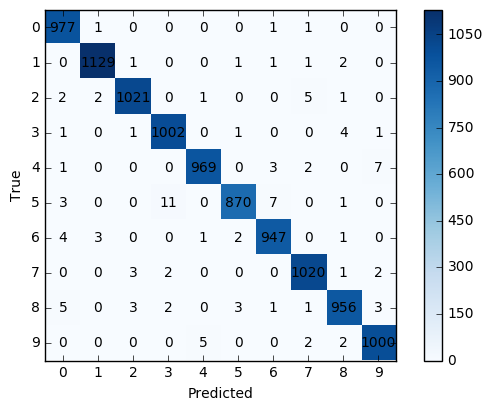

In [23]:
#defined the actual digits of labels again
y_true = data.test.labels
y_true_digit = np.argmax(y_true,axis = 1)

feed_dict_test = {x: data.test.images,
                           y_label: data.test.labels}
save_MDir = 'models/'
save_model = os.path.join(save_MDir,'best_accuracyd')    
saver2restore = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2restore.restore(sess = sess, save_path= save_model)
    print("Restored values:\n")    
    print_acc()
    # find the predicted labels
    y_pred = sess.run(y_pred_digit, feed_dict = feed_dict_test)

    # get the confusion matrix
    conf_mat = confusion_matrix( y_true_digit,
                             y_pred)
    digits = np.array([np.linspace(0,9,10)])
    plot_confusion_matrix(conf_mat, digits)

Note it will take a bit of time, a few seconds to run the print acc code. 